[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/model_cleanup/scripts/interactive/example_bundeslaender.ipynb)

In [1]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git



# Hierarchical Bayesian Model for all German states (Bundeslaender).

Runtime ~ 1h

This file creates the model with three changing points of the paper https://science.sciencemag.org/content/early/2020/05/14/science.abb9789.

## Importing modules


In [2]:
import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

In [3]:
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19



## Creating the model

This cell downloads data and builds the pymc3 model for the Bayesian inference.
More information can be found in the
[documentation](https://covid19-inference.readthedocs.io/en/latest/doc/gettingstarted.html).


In [4]:
# Dates to obtain the data from
date_begin_data = datetime.datetime(2020, 3, 10)
date_end_data = datetime.datetime(2020, 4, 19)

In [5]:
# Downloads 2-D array of new cases (for each state) from the Robert Koch Institute
rki = cov19.data_retrieval.RKI(True)
df_bundeslaender = rki.filter_all_bundesland(date_begin_data, date_end_data)
new_cases_obs = np.diff(np.array(df_bundeslaender), axis=0)[:, :]

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded data from local


In [6]:
# 1D array of state population, ordered alphabetically
N_state = [
    10880000,
    12844000,
    3520000,
    2485000,
    671000,
    1787000,
    6176000,
    7927000,
    1612000,
    17865000,
    4053000,
    996000,
    4085000,
    2245000,
    2859000,
    2171000,
]

In [7]:
# Number of days the simulation starts earlier than the data.
# Should be significantly larger than the expected delay in order to always fit the same number of data points.
diff_data_sim = 16
# Number of days in the future (after date_end_data) to forecast cases
num_days_forecast = 10

In [8]:
# Change point midpoint dates
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 11)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 18)
prior_date_contact_ban_begin = datetime.datetime(2020, 3, 25)

In [9]:
# Structures change points in a dict. Variables not passed will assume default values.
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=0.2,
        pr_sigma_lambda=0.5,
        pr_sigma_transient_len=0.5,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=0.5,
        pr_sigma_transient_len=0.5,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=0.5,
        pr_sigma_transient_len=0.5,
    ),
]

In [10]:
# Stores the model parameters in a dict
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=date_begin_data,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=N_state,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

In [11]:
# The true model is defined in a context manager.
# Check https://docs.pymc.io/notebooks/getting_started.html for details on it.
with cov19.model.Cov19Model(**params_model) as this_model:

    # Create the array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference. It is not
    # necessary to use it, one can simply remove it and use the default argument for
    # pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
    )

    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        pr_mean_of_median=pr_delay,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inferen



## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [12]:
trace = pm.sample(model=this_model, tune=1000, draws=1000, init="advi+adapt_diag")

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 3,273.3:  25%|██▌       | 50699/200000 [03:00<08:52, 280.18it/s]
Convergence achieved at 50700
INFO     [pymc3.variational.inference] Convergence achieved at 50700
Interrupted at 50,699 [25%]: Average Loss = 3,684.3
INFO     [pymc3.variational.inference] Interrupted at 50,699 [25%]: Average Loss = 3,684.3
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_hc_L2_log_raw_, weekend_factor_hc_L1_log, sigma_weekend_factor, delay_hc_L2_log_raw_, delay_hc_L1_log, delay_hc_sigma, I_begin_ratio_log, mu, transient_len_3_hc_L2_log_raw_, transient_len_3_hc_L1_log, sigma_transient_len_3, transient_len_2_hc_L2_log_raw_, transient_len_2_hc_L1_log, sigma_transient_len_2, transient_len_1_hc_L2_log_raw_,



# Plotting

We below plot the posterior distributions of selected parameters,
and the resulting number of cases for each state.

### Variables

The model uses a large number of parameters, and internally creates new versions
(e.g. var_log_) for handling. All defined parameters can be found in
`trace.varnames`, and the corresponding traces are found in `trace[varname]`.

### Violin plots


In [13]:
# Defines plotted variables, their names and plotting range
var_names = {
    "delay_hc_L2": {"name": "delay", "xlim": [0, 14]},
    "I_begin": {"name": r"$I_0$", "xlim": [0, 300]},
    "lambda_0_hc_L2": {"name": r"$\lambda_0$", "xlim": [0, 1]},
    "lambda_1_hc_L2": {"name": r"$\lambda_1$", "xlim": [0, 1]},
    "lambda_2_hc_L2": {"name": r"$\lambda_2$", "xlim": [0, 1]},
    "lambda_3_hc_L2": {"name": r"$\lambda_3$", "xlim": [0, 1]},
    "transient_day_1_hc_L2": {"name": r"$t_1$", "xlim": [10, 40]},
    "transient_day_2_hc_L2": {"name": r"$t_2$", "xlim": [10, 40]},
    "transient_day_3_hc_L2": {"name": r"$t_3$", "xlim": [10, 40]},
}

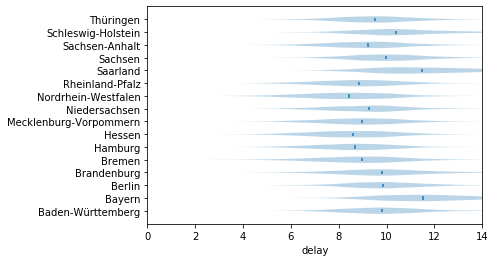

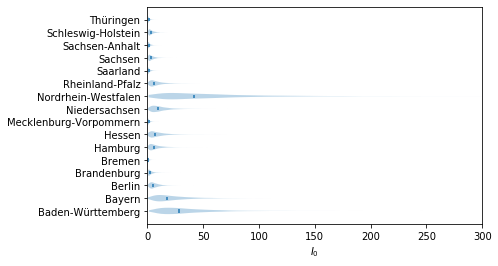

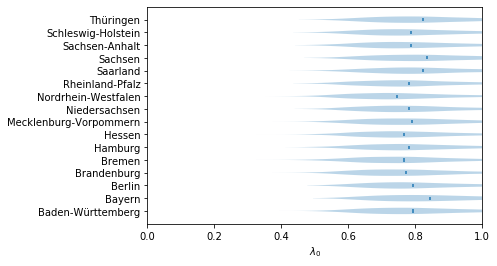

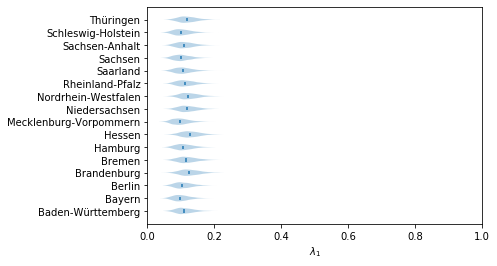

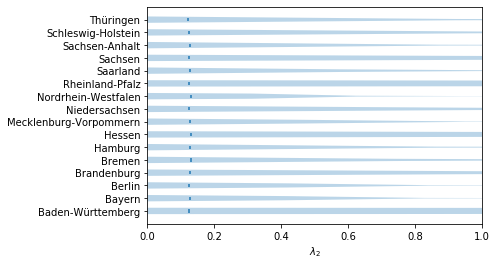

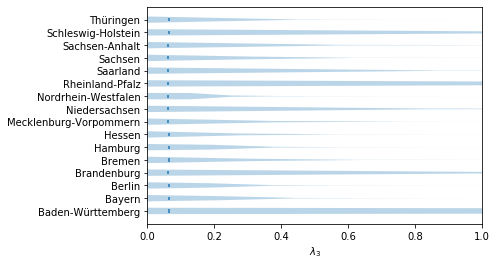

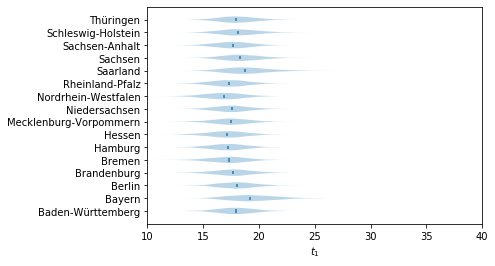

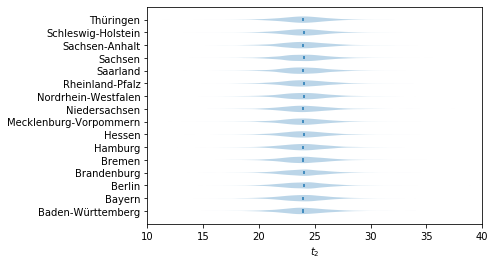

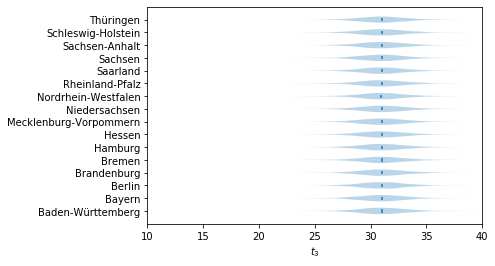

In [14]:
# Plots violin plots
for var_name in var_names.keys():
    f, ax = plt.subplots()
    ax.violinplot(trace[var_name], showextrema=False, vert=False, showmedians=True)
    ax.set_yticks(np.arange(1, 17))
    ax.set_yticklabels(df_bundeslaender.columns)
    ax.set_xlabel(var_names[var_name]["name"])
    ax.set_xlim(var_names[var_name]["xlim"])



### Timeseries

For every region (bundesland) we create a timeseries plot. For now new cases! TODO more


In [15]:
# First define the x range on which we want to plot. Should be within the simulation period.
bd = datetime.datetime(2020, 3, 10)
ed = datetime.datetime(2020, 4, 19) + datetime.timedelta(days=num_days_forecast - 1)

In [16]:
# Next we have to get our trace corresponding to that date range. We do that by calling the helper function `cov19.plot._get_array_from_trace_via_date()`.
y_all_regions, x = cov19.plot._get_array_from_trace_via_date(
    this_model, trace, "new_cases", bd, ed
)

In [ ]:
# After retrieving the trace var for our specified time period, we plot the timeseries for each region. Additionaly we set the format of the date (x-)axis.
# We have 16 regions in this example -> we create 16 subplots
fig, axes = plt.subplots(16, 1, figsize=(10, 35))

In [18]:
for i in range(16):
    y = y_all_regions[:, :, i]
    cov19.plot._timeseries(x, y, axes[i], what="fcast")
    axes[i].set_title(df_bundeslaender.columns[i])
    cov19.plot._format_date_xticks(axes[i])

/home/sebastian/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [19]:
# Furthermore, we can plot our observable i.e. our new_cases_obs.
x_dat = pd.date_range(this_model.data_begin, this_model.data_end)
for i in range(16):
    y = new_cases_obs[:, i]
    cov19.plot._timeseries(x_dat, y, axes[i], what="data", lw=0)

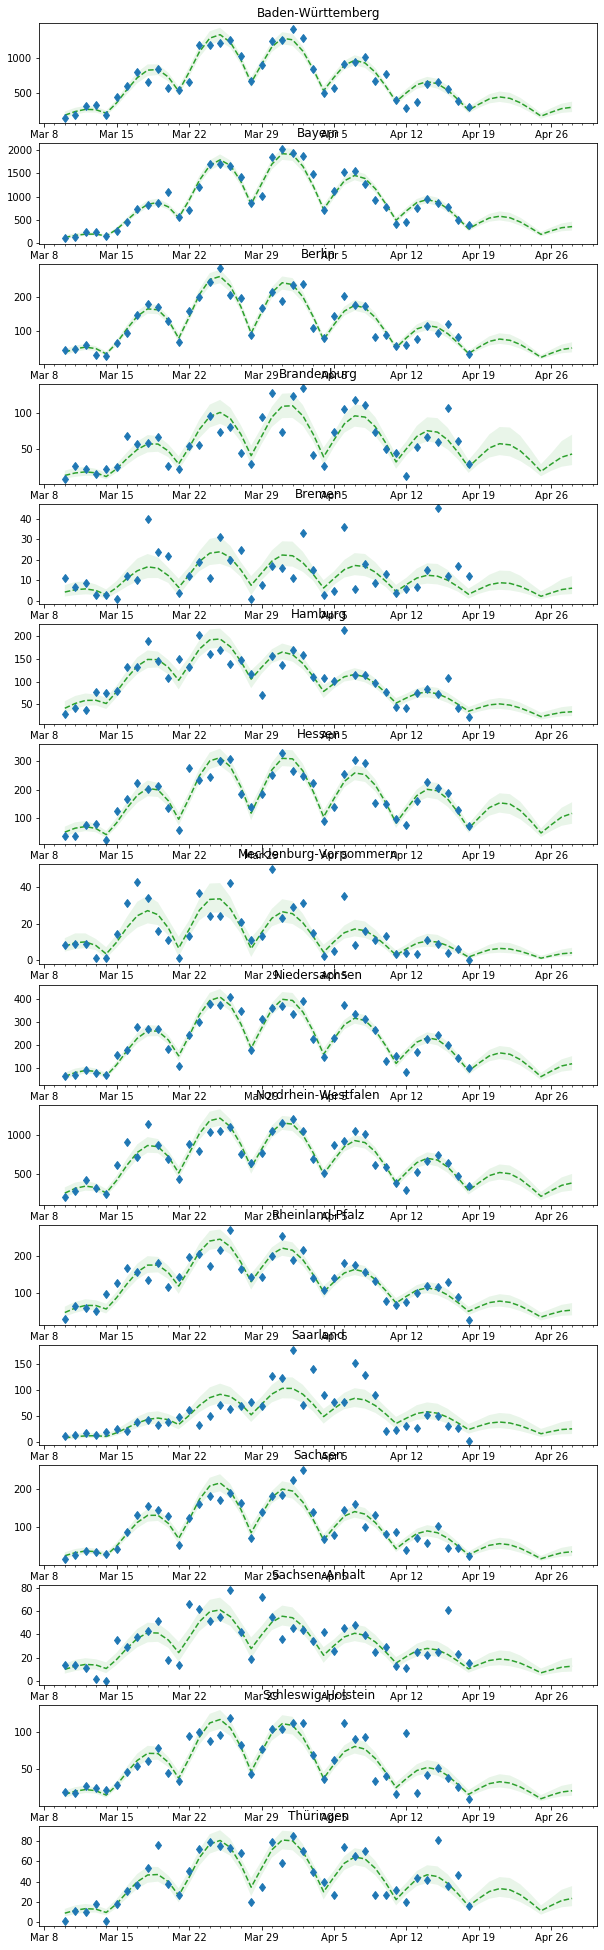

<Figure size 432x288 with 0 Axes>

In [20]:
plt.tight_layout()
fig #To show figure in jupyter notebook